## Importing required libraries

In [1]:
#Importing the required libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import shap
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from boruta import BorutaPy

from pprint import pprint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score
#from pyearth import Earth
from sklearn.svm import SVR
from pygam import LinearGAM
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Importing the dataset 

In [2]:
# Read & Display data
data1 = pd.read_csv("C:/Users/Aman.aggarwal/Documents/Exelon/Chem Sampling/wine.csv")
data = data1.copy()
data.head()

,Transaction_date,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1/2/2009 4:53,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1/2/2009 13:08,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1/4/2009 12:56,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1/4/2009 13:19,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1/4/2009 20:11,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Initialising the class 

In [3]:
class Data:
    def __init__(self,df, pfeatures, target):
        '''
        function to intialise the class object 
        @params
        df = dataframe containing all the data with target variable 
        pfeatures=  list of columns other than target to do feature selection
        target = target variable in list
        '''
        self.df = df
        self.pfeatures = pfeatures
        self.target = target 
        

### Outlier Detection & Treatment

In [5]:
class Outliers(Data):
    
    def __init__(self, Data):
        '''
        function to intialise the class object 
        '''
        self.data = Data.df
        self.pfeatures = Data.pfeatures

    
    def box_plot(self, variable):
        '''
        function to plot the box plot 
        outliers could be visualized using this
        Accepts variable name as an argument
        '''
        df = self.data.copy()
        sns.boxplot(data=df,x=df[variable])
    
    def iqr_method(self, variable):
        '''
        function identifies outliers based on IQR method
        Accepts variable name(as string) as an argument
        Returns two dataframes :
        - first df without outliers 
        - second df with outliers
        '''
        df = self.data.copy()
        q1 = df[variable].quantile(0.25)
        q3 = df[variable].quantile(0.75)
        iqr = q3-q1
        inner_fence = 1.5*iqr
        outer_fence = 3*iqr
    
        #inner fence lower and upper end
        inner_fence_le = q1-inner_fence
        inner_fence_ue = q3+inner_fence
        
        df_include = df.loc[(df[variable] >= inner_fence_le) & \
                            (df[variable] <= inner_fence_ue)] # meeting the acceptable range
        df_exclude = df.loc[(df[variable] < inner_fence_le) | \
                            (df[variable] > inner_fence_ue)] #not meeting acceptable range
        
        #outer fence lower and upper end
        outer_fence_le = q1-outer_fence
        outer_fence_ue = q3+outer_fence
        
        outliers_prob = []
        outliers_poss = []
        for index, x in enumerate(df[variable]):
            if x <= outer_fence_le or x >= outer_fence_ue:
                outliers_prob.append(index)
        for index, x in enumerate(df[variable]):
            if x <= inner_fence_le or x >= inner_fence_ue:
                outliers_poss.append(index)
        return df_include, df_exclude
         
    def z_score(self, variable_name):
        '''
        function identifies outliers based on Z-score method
        Accepts variable name(as string) as an argument
        Returns two dataframes :
        - first df without outliers 
        - second df with outliers
        '''
        df = self.data.copy()
        z = np.abs(stats.zscore(df[variable_name]))
        threshold = 3
        df_include = df[(z < threshold)]
        df_exclude = df[(z > threshold)]
        return df_include, df_exclude
    
    def mad_score(self, variable_name):
        '''
        function identifies outliers based on MAD(Median Absolute Deviation) method
        Accepts variable name(as string) as an argument
        Returns two dataframes :
        - first df without outliers 
        - second df with outliers
        '''
        df = self.data.copy()
        median = np.median(df[variable_name], axis = 0)
        mad = np.abs(stats.median_absolute_deviation(df[variable_name]))
        score = (df[variable_name] - median)/mad
        threshold = 3
        df_include = df[score < threshold]
        df_exclude = df[score > threshold]
        return df_include, df_exclude
    
    def imput_mean(self, df1, df2, variable_name):
        '''
        function imputes the outlier values with mean
        Accepts three argument:
        - first df without outliers 
        - second df with outliers
        - variable name(as string)
        Returns dataframe
        '''
        mean = int(df1[variable_name].mean())
        df2[variable_name] = mean
        df = pd.concat([df1, df2]) #concatenating both dfs to get the original shape
        return df
    
    def imput_median(self, df1, df2, variable_name):
        '''
        function imputes the outlier values with median
        Accepts three argument:
        - first df without outliers 
        - second df with outliers
        - variable name(as string)
        Returns dataframe
        '''
        median = int(df1[variable_name].median())
        df2[variable_name] = median
        df = pd.concat([df1, df2]) #concatenating both dfs to get the original shape
        return df
    
    def imput_mode(self, df1, df2, variable_name):
        '''
        function imputes the outlier values with mode
        Accepts three argument:
        - first df without outliers 
        - second df with outliers
        - variable name(as string)
        Returns dataframe
        '''
        mode = int(df1[variable_name].mode())
        df2[variable_name] = mode
        df = pd.concat([df1, df2]) #concatenating both dfs to get the original shape
        return df

    def capping(self, df1, df2, variable_name, low, high):
        '''
        function caps the outlier value
        Accepts three argument:
        - first df without outliers 
        - second df with outliers
        - variable name(as string)
        - low (lower bound value for capping if outlier value is below it)
        - high (upper bound value for capping if outlier value is above it)
        Returns dataframe
        '''
        #low = df1[variable_name].min()
        #high = df1[variable_name].max()
        df2.loc[df2[variable_name] <low, variable_name] = low
        df2.loc[df2[variable_name] >high, variable_name] = high
        df = pd.concat([df1, df2])
        return df
    

#### Creating class instance, Implementing methods
Below are the functions under outlier class
- box_plot('col_name')
- iqr_method('col_name')
- z_score('col_name')
- mad_score('col_name')
- imput_mean(df1(without outliers), df2(with outliers), 'col_name')
- imput_median(df1(without outliers), df2(with outliers), 'col_name')
- imput_mode(df1(without outliers), df2(with outliers), 'col_name')
- capping(df1(without outliers), df2(with outliers), 'col_name', low(lower cap value), high(upper cap value))

In [4]:
#Assigning the dependent & independent variable
pfeatures = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
             'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
target=['Alcohol']
r = Data(data, pfeatures, target)

# #Getting all columns and removing the one not required
# pfeatures = list(data.columns)
# pfeatures.remove('Alcohol')
# print(pfeatures)

In [6]:
outlier = Outliers(r)

In [7]:
# IQR Method
df_without_outlier, df_with_outlier = outlier.iqr_method("Alcohol")
print(df_without_outlier.shape)
print(df_with_outlier.shape)

(178, 14)
(0, 14)


In [8]:
df_without_outlier.head(1)

,Transaction_date,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1/2/2009 4:53,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065


In [9]:
# Z-Score Method
df_without_outlier, df_with_outlier = outlier.z_score('Alcohol')
print(df_without_outlier.shape)
print(df_with_outlier.shape)

(178, 14)
(0, 14)


In [10]:
# Imputing with mean
df_mean = outlier.imput_mean(df_without_outlier, df_with_outlier, 'Alcohol')

In [11]:
df_mean.head()

,Transaction_date,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1/2/2009 4:53,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1/2/2009 13:08,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1/4/2009 12:56,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1/4/2009 13:19,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1/4/2009 20:11,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Normalization 

In [16]:
class Normalization(Data):
    
    def __init__(self, Data):
        '''
        function to intialise the class object 
        '''
        self.data = Data.df
        self.pfeatures = Data.pfeatures
        self.pfeatures.append(target)
    
    def plot(self, x):
        '''
        function to plot:
        Distplot : It represents the univariate distribution of data 
        i.e. data distribution of a variable against the density distribution
        Probability Plot :The data are plotted against a theoretical distribution
        in such a way that the points should form approximately a straight line.
        Accepts data variable as argument
        '''
        sns.set(rc={'figure.figsize':(16,5)})
        sns.set_style("white")
        sns.distplot(x,fit=norm);
        fig = plt.figure()
        print('\n')
        res = stats.probplot(x, plot=plt)
        fig = plt.figure()
    
    def log_transform(self, x):
        '''
        function to log tranform the data variable
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = np.log(x)
        self.plot(x)
        return x
    
    def scaling(self, x):
        '''
        function for scaling of the data variable
        Data is rescaled and new values are in [0, 1]
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = x/x.max()
        self.plot(x)
        return x
    
    def min_max_scaling(self, x):
        '''
        function for min-max scaling of the data variable
        Data is rescaled and new values are in [0, 1]
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = (x - x.min())/(x.max() - x.min())
        self.plot(x)
        return x
    
    def z_score_scaling(self, x):
        '''
        function for scaling of the data variable using the z-score method
        Data will have a Gaussian distribution with μ=0 and σ=1
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = (x - x.mean())/x.std()
        self.plot(x)
        return x
    
    def sq_root(self, x):
        '''
        function for square-root transformation of the data variable
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = x**(1/2)
        self.plot(x)
        return x
    
    def cube_root(self, x):
        '''
        function for cube-root transformation of the data variable
        Accepts data variable as argument
        Returns the transformed data variable
        '''
        x = x**(1/3)
        self.plot(x)
        return x
    
    def transform_log(self, feature = None):
        '''
        function for log transformation of the data variable
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.log_transform(df[feature[i]])
        return df
    
    def transform_scaling(self, feature = None):
        '''
        function for scaling of the data variable
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.scaling(df[feature[i]])
        return df
    
    def transform_minmax(self, feature = None):
        '''
        function for scaling of the data variable using min-max scaling
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.min_max_scaling(df[feature[i]])
        return df
    
    def transform_zscore(self, feature = None):
        '''
        function for scaling of the data variable using z-score method
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.z_score_scaling(df[feature[i]])
        return df
    
    def transform_sqroot(self, feature = None):
        '''
        function for square-root transformation of the data variable
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.sq_root(df[feature[i]])
        return df
    
    def transform_cuberoot(self, feature = None):
        '''
        function for cube-root transformation of the data variable
        Accepts features which need to be transformed as argument
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        for i in range(len(feature)):
            df[feature[i]] = self.cube_root(df[feature[i]])
        return df
    
    def transform(self, method, feature = None):
        '''
        function for transformation of the data variable
        Accepts features which need to be transformed as argument and method number to be used
        1:Log, 2:Scaling, 3:Min-Max Scaling, 4:Z-Score Scaling, 5:Square-root, 6:Cube-root
        Returns the transformed dataframe(with specific columns transformed if specified)
        '''
        df = self.data.copy()
        feature = feature
        if(len(feature) != 0):
            feature = feature
        else:
            feature = self.pfeatures
        if(method == 1):
            for i in range(len(feature)):
                df[feature[i]] = self.log_transform(df[feature[i]])
        elif(method == 2):
            for i in range(len(feature)):
                df[feature[i]] = self.scaling(df[feature[i]])
        elif(method == 3):
            for i in range(len(feature)):
                df[feature[i]] = self.min_max_scaling(df[feature[i]])
        elif(method == 4):
            for i in range(len(feature)):
                df[feature[i]] = self.z_score_scaling(df[feature[i]])
        elif(method == 5):
            for i in range(len(feature)):
                df[feature[i]] = self.sq_root(df[feature[i]])
        elif(method == 6):
            for i in range(len(feature)):
                df[feature[i]] = self.cube_root(df[feature[i]])
        return df
    
    

#### Creating class object, Implementing methods
Below are the functions of normalization class
- m.plot(data['col_name'])
- m.log_transform(data['col_name'])
- m.scaling(data['col_name'])
- m.min_max_scaling(data['col_name'])
- m.z_score_scaling(data['col_name'])
- m.sq_root(data['col_name'])
- m.cube_root(data['col_name'])
- m.transform(2, feature = optional) - 1:Log, 2:Scaling, 3:Min-Max Scaling, 4:Z-Score Scaling, 5:Square-root, 6:Cube-root

In [14]:
#Assigning the dependent & independent variable
pfeatures = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
             'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
target=['Alcohol']
r = Data(df_mean, pfeatures, target)

# #Getting all columns and removing the one not required
# pfeatures = list(data.columns)
# pfeatures.remove('Alcohol')
# print(pfeatures)

In [17]:
m = Normalization(r)

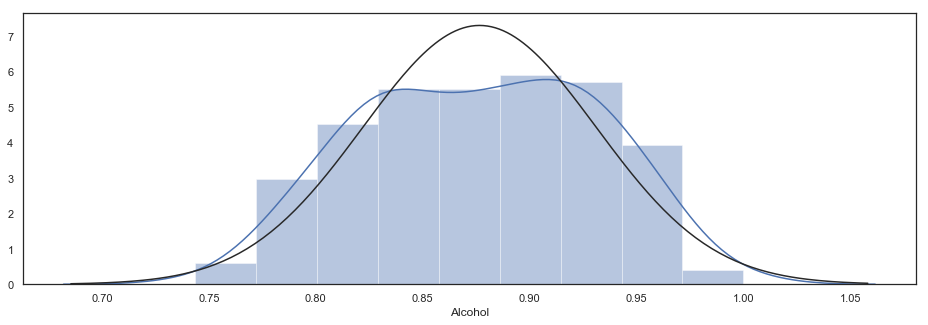

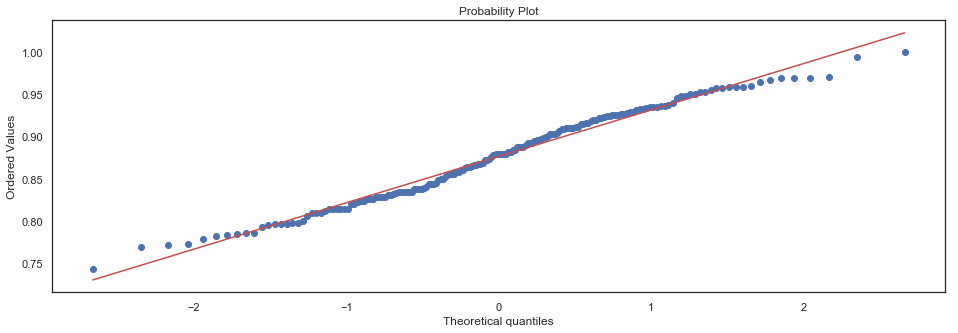

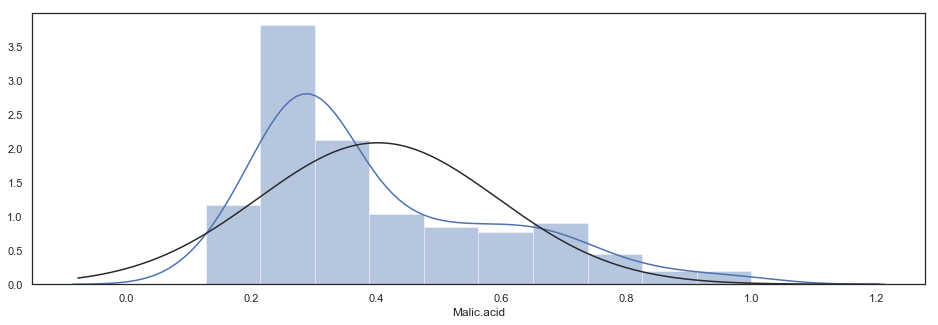

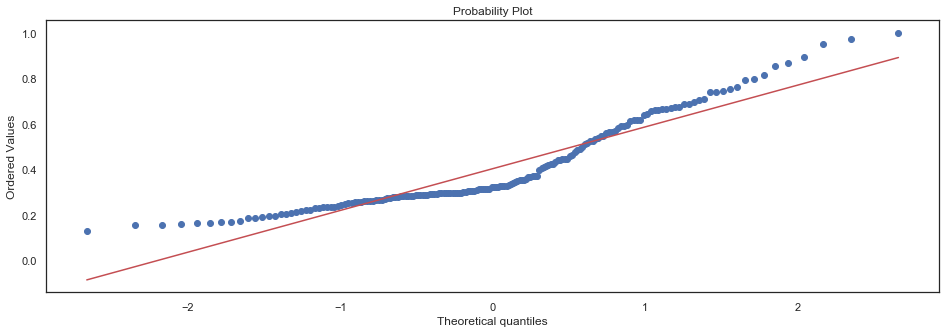

<Figure size 1152x360 with 0 Axes>

In [18]:
#Implementation of transform function
feature = ['Alcohol', 'Malic.acid']
df2 = m.transform(2, feature) #returned the transformed df (only specific columns transformed if specified)

In [19]:
#Transformed dataframe(only Alcohol and Malic acid is transformed)
df2.head()

,Transaction_date,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1/2/2009 4:53,0.959541,0.294828,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1/2/2009 13:08,0.890088,0.306897,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1/4/2009 12:56,0.887390,0.406897,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1/4/2009 13:19,0.968982,0.336207,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1/4/2009 20:11,0.892785,0.446552,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Feature Selection 

In [20]:
class FeatureSelection(Data):
    
    def __init__(self, Data, n_feature):
        '''
        function to intialise the class object 
        '''
        self.df = Data.df
        self.pfeatures = Data.pfeatures
        self.target = Data.target
        self.feature_results = pd.DataFrame()
        self.n_feature = n_feature
        self.union_feature = []
        self.inter_feature = []
    
    def recursive(self,estimator):
        '''
        function to do recursive feature selection and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        selector = RFE(estimator, 
                       n_features_to_select= self.n_feature, step=1)
        selector = selector.fit(self.df[self.pfeatures], 
                                self.df[self.target].values.ravel())
        temp = pd.DataFrame({"Features":self.pfeatures,
                             "Ranking":selector.ranking_,
                             "Method":'RFE'})
        temp = temp.sort_values('Ranking')
        
        temp1 = temp.head(self.n_feature)
        self.inter_feature = temp1['Features'].tolist()
        self.union_feature = temp1['Features'].tolist()
        self.feature_results=self.feature_results.append(temp)
        #print("Overall Accuracy using RFE: ", selector.score(self.df[self.pfeatures],self.df[self.target].values.ravel()))
        return temp

    def coefficient_based(self,estimator):
        '''
        function to do coefficient based feature selection and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        selector = SelectFromModel(estimator)
        selector = selector.fit(self.df[self.pfeatures], 
                                self.df[self.target].values.ravel())
        temp=pd.DataFrame({"Features":self.pfeatures,
                           "Selected":selector.get_support(),
                           "Selected_coef": selector.estimator_.coef_[0],
                           "Method":'Coefficient_based',
                           "Threshold":selector.threshold_})
        temp = temp.sort_values(by=['Selected'], ascending=False)
        
        temp1 = temp.head(self.n_feature)
        temp1_list = temp1['Features'].tolist()
        self.inter_feature = list(set(self.inter_feature) & set(temp1_list))
        self.union_feature = self.union_feature + temp1_list
        self.feature_results= self.feature_results.append(temp)
        return temp

    def ShAP_XGB(self, estimator):
        '''
        function to consider all possible predictions for an instance using all
        possible combinations of inputs based on elements of game theory and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        #Implemeting the feature selection using ShAP
        model = estimator
        # Fit the Model
        model.fit(self.df[self.pfeatures], 
                  self.df[self.target].values.ravel())

        # load JS visualization code to notebook
        #shap.initjs()

        #Collect the explainer and the shap_values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(self.df[self.pfeatures])

        #Plot a standard bar plot
        #shap.summary_plot(shap_values, features=self.df[self.pfeatures], feature_names=self.df[self.pfeatures].columns, plot_type='bar')
        #shap.summary_plot(shap_values, features=self.df[self.pfeatures], feature_names=self.df[self.pfeatures].columns)
        shap_sum = np.abs(shap_values).mean(axis=0)
        importance_df = pd.DataFrame([self.df[self.pfeatures].columns.tolist(), shap_sum.tolist()]).T
        importance_df.columns = ['Features', 'shap_importance']
        importance_df = importance_df.sort_values('shap_importance', ascending=False)
        importance_df['Method'] = 'ShAP'
        
        temp1 = importance_df.head(self.n_feature)
        temp1_list = temp1['Features'].tolist()
        self.inter_feature = list(set(self.inter_feature) & set(temp1_list))
        self.union_feature = self.union_feature + temp1_list
        self.feature_results= self.feature_results.append(importance_df)
        return importance_df
    
    def Boruta_rf(self, estimator):
        '''
        function selects the features that actually have relationship with outcome variable
        The algorithm reshuffles the data to create shadow features
        It eliminates the features that have significantly worst importance than shadow ones
        There are few limitations in the approach and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        rf_model = estimator
        feat_selector = BorutaPy(rf_model,n_estimators = 'auto', verbose= 0,max_iter= 100)
        feat_selector.fit(self.df[self.pfeatures].values, self.df[self.target].values.ravel())
        temp = pd.DataFrame({"Features":self.pfeatures,
                             "Ranking":feat_selector.ranking_,
                             "Method":'Boruta'})
        temp = temp.sort_values('Ranking')
        
        temp1 = temp.head(self.n_feature)
        temp1_list = temp1['Features'].tolist()
        self.inter_feature = list(set(self.inter_feature) & set(temp1_list))
        self.union_feature = self.union_feature + temp1_list
        self.feature_results=self.feature_results.append(temp)
        return temp
    
    def Var_threshold(self, threshold_value):
        '''
        function selects the features based on the defined threshold taking 
        into consideration the multicollinearity and accepts threshold_value
        as parameter 
        '''
        selector = VarianceThreshold(threshold = threshold_value)
        selector.fit(self.df[self.pfeatures])
        #selector.get_support()
        temp = pd.DataFrame({"Features":self.pfeatures,
                             "Ranking":selector.get_support(),
                             "Method":'Variance Threshold'})
        temp = temp.sort_values(by=['Ranking'], ascending=False)
        
        temp1 = temp.head(self.n_feature)
        temp1_list = temp1['Features'].tolist()
        self.inter_feature = list(set(self.inter_feature) & set(temp1_list))
        self.union_feature = self.union_feature + temp1_list
        self.feature_results=self.feature_results.append(temp)
        return temp


In [21]:
#Assigning the dependent & independent variable
pfeatures = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
             'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
target=['Alcohol']

#Creating the object for Data function
r= Data(df2, pfeatures, target)

In [22]:
#Creating the object for feature selection and specifying the number of features 
m = FeatureSelection(r, 5)

#Assigning the models
estimator1 = DecisionTreeRegressor()
estimator2 = SVR(kernel="linear")
estimator3 = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
estimator4 = RandomForestRegressor(n_jobs= 4, oob_score= True)

In [23]:
#Calling the RFE function
m.recursive(estimator1)

,Features,Ranking,Method
1,Ash,1,RFE
4,Phenols,1,RFE
6,Nonflavanoid.phenols,1,RFE
8,Color.int,1,RFE
11,Proline,1,RFE
9,Hue,2,RFE
0,Malic.acid,3,RFE
5,Flavanoids,4,RFE
2,Acl,5,RFE
7,Proanth,6,RFE


In [24]:
m.coefficient_based(estimator2)

,Features,Selected,Selected_coef,Method,Threshold
0,Malic.acid,True,0.162499,Coefficient_based,0.109256
4,Phenols,True,-0.127438,Coefficient_based,0.109256
5,Flavanoids,True,0.162220,Coefficient_based,0.109256
7,Proanth,True,-0.248070,Coefficient_based,0.109256
8,Color.int,True,0.180297,Coefficient_based,0.109256
10,OD,True,0.292363,Coefficient_based,0.109256
1,Ash,False,0.042729,Coefficient_based,0.109256
2,Acl,False,-0.041879,Coefficient_based,0.109256
3,Mg,False,0.004349,Coefficient_based,0.109256
6,Nonflavanoid.phenols,False,0.029440,Coefficient_based,0.109256


In [25]:
m.ShAP_XGB(estimator3)

,Features,shap_importance,Method
8,Color.int,0.165789,ShAP
11,Proline,0.0288032,ShAP
0,Malic.acid,0,ShAP
1,Ash,0,ShAP
2,Acl,0,ShAP
3,Mg,0,ShAP
4,Phenols,0,ShAP
5,Flavanoids,0,ShAP
6,Nonflavanoid.phenols,0,ShAP
7,Proanth,0,ShAP


In [26]:
m.Boruta_rf(estimator4)

,Features,Ranking,Method
1,Ash,1,Boruta
4,Phenols,1,Boruta
7,Proanth,1,Boruta
8,Color.int,1,Boruta
11,Proline,1,Boruta
0,Malic.acid,2,Boruta
10,OD,3,Boruta
2,Acl,4,Boruta
5,Flavanoids,5,Boruta
9,Hue,6,Boruta


In [27]:
m.Var_threshold(0.8)

,Features,Ranking,Method
0,Malic.acid,True,Variance Threshold
2,Acl,True,Variance Threshold
3,Mg,True,Variance Threshold
5,Flavanoids,True,Variance Threshold
8,Color.int,True,Variance Threshold
11,Proline,True,Variance Threshold
1,Ash,False,Variance Threshold
4,Phenols,False,Variance Threshold
6,Nonflavanoid.phenols,False,Variance Threshold
7,Proanth,False,Variance Threshold


In [28]:
m.feature_results

,Features,Method,Ranking,Selected,Selected_coef,Threshold,shap_importance
1,Ash,RFE,1.0,NaN,NaN,NaN,NaN
4,Phenols,RFE,1.0,NaN,NaN,NaN,NaN
6,Nonflavanoid.phenols,RFE,1.0,NaN,NaN,NaN,NaN
8,Color.int,RFE,1.0,NaN,NaN,NaN,NaN
11,Proline,RFE,1.0,NaN,NaN,NaN,NaN
9,Hue,RFE,2.0,NaN,NaN,NaN,NaN
0,Malic.acid,RFE,3.0,NaN,NaN,NaN,NaN
5,Flavanoids,RFE,4.0,NaN,NaN,NaN,NaN
2,Acl,RFE,5.0,NaN,NaN,NaN,NaN
7,Proanth,RFE,6.0,NaN,NaN,NaN,NaN


In [29]:
#Get union of n_features from all feature selection methods
Union_Final_feature = list(set(m.union_feature)) 
Union_Final_feature

['Mg',
 'Color.int',
 'Phenols',
 'Nonflavanoid.phenols',
 'Ash',
 'Proanth',
 'Proline',
 'Acl',
 'Flavanoids',
 'Malic.acid']

In [30]:
#Get intersection of n_features from all feature selection methods
Intersection_Final_feature = m.inter_feature
Intersection_Final_feature

['Color.int']

## Regresion 

In [60]:
class Reg_data:
    def __init__(self,df, pfeatures, target, date, split):
        '''
        function to intialise the class object 
        @params
        df = dataframe containing all the data with target variable 
        pfeatures=  list of columns other than target to do feature selection
        target = target variable in list
        date = Date column name as string
        split = by what value data to be splitted for holdout sample
        '''
        self.df = df
        self.pfeatures = pfeatures
        self.target = target 
        self.date = date
        self.split = split
        self.date_train = pd.DataFrame()
        self.date_test = pd.DataFrame()
        X = self.df #[pfeatures]
        X['D1'] = X[self.date].apply(pd.to_datetime)
        X['Date'] = X['D1'].dt.date
        print(X.shape)
        y = self.df[self.target]
        print(y.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.split, random_state=42)
        self.date_train['Date'] = self.X_train['Date']
        self.date_test['Date'] = self.X_test['Date']
        self.X_train = self.X_train[pfeatures]
        self.X_test = self.X_test[pfeatures]
        print(self.date_train.shape, self.date_test.shape)
        print(self.X_train.shape, self.X_test.shape)
        print(self.y_train.shape, self.y_test.shape)
        

In [90]:
class Regression_model(Reg_data):
    
    def __init__(self, Reg_data):
        '''
        function to intialise the class object 
        '''
        self.df = Reg_data.df
        self.pfeatures = Reg_data.pfeatures
        self.target = Reg_data.target
        self.X_train = Reg_data.X_train
        self.X_test = Reg_data.X_test
        self.y_train = Reg_data.y_train
        self.y_test = Reg_data.y_test
        self.date_train = Reg_data.date_train
        self.date_test = Reg_data.date_test
        self.params = {}
        self.model_result_df = pd.DataFrame()
        
    # calculate mape scores
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # calculate rmse scores
    def rmse(self, pred_test, y_test):
        pred_test, y_test = np.array(pred_test), np.array(y_test)
        return np.sqrt(((pred_test - y_test) ** 2).mean())
    
    def plot(self, predictions1):
        plt.figure(figsize=(6, 5))
        with plt.style.context('ggplot'):
            y_test, predictions = np.array(self.y_test), np.array(predictions1)
            y_test, predictions = y_test.ravel(), predictions.ravel()
            plt.scatter(y_test, predictions, color='red')
            plt.plot(y_test, y_test, '-g', label='Expected regression line')
            z = np.polyfit(y_test, predictions, 1)
            plt.plot(np.polyval(z, y_test), y_test, color='blue', label='Predicted regression line')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.legend()
            plt.plot()
            
    def series_plot(self, train_pred, test_pred, upper_threshold, lower_threshold):
        # Train Data Plot
        date_train = self.date_train
        date_train['Actuals'] = self.y_train
        date_train['predictions'] = train_pred
        print(date_train.shape)
        plt.figure(figsize=(16,6)) # Figure size
        sns.lineplot(x='Date', y='Actuals', data=date_train, ci = None, marker = 'o')
        sns.lineplot(x='Date', y='predictions', data=date_train, ci = None, marker = 'o')
        plt.axhline(y = upper_threshold, color = 'b', linestyle = ':', label = "blue line")
        plt.axhline(y = lower_threshold, color = 'r', linestyle = 'dashed', label = "red line") 
        plt.ylabel("Actuals & Predicted")
        plt.title('Train Data') # Title
        plt.xticks(rotation=20)
        plt.legend(('Actuals','Predicted', 'Upper limit', 'Lower limit'), bbox_to_anchor = (1.0, 1),loc = 'upper center') #bbox_to_anchor = (1.0, 1),loc = 'upper center')
        plt.show()
        
        #Test Data Plot
        date_test = self.date_test
        date_test['Actuals'] = self.y_test
        date_test['predictions'] = test_pred
        print(date_test.shape)
        plt.figure(figsize=(16,6))
        sns.lineplot(x='Date', y='Actuals', data=date_test, ci = None, marker = 'o')
        sns.lineplot(x='Date', y='predictions', data=date_test, ci = None, marker = 'o')
        plt.axhline(y = upper_threshold, color = 'b', linestyle = ':', label = "blue line")
        plt.axhline(y = lower_threshold, color = 'r', linestyle = 'dashed', label = "red line") 
        plt.ylabel("Actuals & Predicted")
        plt.title('Validation Data') 
        plt.xticks(rotation=20)
        plt.legend(('Actuals','Predicted', 'Upper limit', 'Lower limit'), loc = 'lower right')
        plt.show()
    
    def fit_model(self, estimator, param = None):
        '''
        function for fitting the model and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        # fit a model
        lm = estimator
        self.param = param
        res = not bool(self.param)
        if(res == False):
            lm.set_params(**param)
            model = lm.fit(self.X_train, self.y_train)
        else:
            model = lm.fit(self.X_train, self.y_train)
        
        return model
    
    def train_predict(self, fitted_model):
        '''
        function for doing the prediction on fitted model and accepts
        fitted_model as parameter
        Returns the predicted values for train and test dataset
        '''
        train_predictions = fitted_model.predict(self.X_train)
        predictions = fitted_model.predict(self.X_test)
        
        return train_predictions, predictions
    
    def model_eval(self, train_predictions, predictions, model_name):
        '''
        function for evaluating the model and accepts predictions
        as parameter
        Returns the dataframe with mse, rmse, mae, mape & r2
        '''
        n = len(self.y_train)
        mse_train = mean_squared_error(self.y_train, train_predictions)
        rmse_train = self.rmse(self.y_train, train_predictions.reshape(n,1))
        mae_train = mean_absolute_error(self.y_train, train_predictions)
        mape_train = self.mean_absolute_percentage_error(self.y_train, train_predictions)
        r2_train = r2_score(self.y_train, train_predictions)

        m = len(predictions)
        mse_test = mean_squared_error(self.y_test, predictions)
        rmse_test = self.rmse(self.y_test, predictions.reshape(m,1))
        mae_test = mean_absolute_error(self.y_test, predictions)
        mape_test = self.mean_absolute_percentage_error(self.y_test, predictions)
        r2_test = r2_score(self.y_test, predictions)
        
        temp = pd.DataFrame({"MODEL_NAME" : model_name,
                             "TRAIN_MSE" : [mse_train],
                             "TRAIN_RMSE": rmse_train,
                             "TRAIN_MAE" : [mae_train],
                             "TRAIN_MAPE": mape_train,
                             "TRAIN_R2": [r2_train],
                             "TEST_MSE" : [mse_test],
                             "TEST_RMSE": rmse_test,
                             "TEST_MAE" : [mae_test],
                             "TEST_MAPE": mape_test,
                             "TEST_R2": [r2_test]})
        return temp
    
    def store_res(self,  temp):
        '''
        function for storing evaluation of the model and accepts 
        dataframe having evaluated scores with model name as parameter
        Returns the whole dataframe with different models stored
        '''
        self.model_result_df=self.model_result_df.append(temp)
        self.model_result_df=self.model_result_df.drop_duplicates(subset ="MODEL_NAME", keep = 'first')
        return self.model_result_df
    
    def best_model(self, metric = 'TEST_MAPE'):
        '''
        function for storing best evaluated model and accepts 
        optional parameter as in which metric to use by default is mape
        Returns the model with best metrics 
        '''
        result = self.model_result_df.sort_values(by = metric)
        return result.head(1)
    
    def randomized_search(self, estimator, random_grid, iterations, cv):
        '''
        function for randomized search and accepts following as parameter:
        estimator : sklearn ML algorithm object 
        random_grid : Dictionary of the parameters to be used for random search
        iterations : Number of iterations to be performed
        cv : Number of cross validations
        '''
        rs = estimator
        model = RandomizedSearchCV(estimator = rs, param_distributions = random_grid, n_iter = iterations, cv = cv,
                                      verbose=5, scoring='neg_mean_absolute_error', random_state=1234, n_jobs = -1)
        model.fit(self.X_train, self.y_train)
        return model
    
    def grid_search(self, estimator, random_grid, cv):
        '''
        function for grid search and accepts following as parameter:
        estimator : sklearn ML algorithm object 
        random_grid : Dictionary of the parameters to be used for grid search
        cv : Number of cross validations
        '''
        rs = estimator
        model = GridSearchCV(estimator = rs, param_grid = random_grid, cv = cv,
                                      verbose=5, scoring='neg_mean_absolute_error', n_jobs = -1)
        model.fit(self.X_train, self.y_train)
        return model
    
    def model_run(self, estimator, model_name, param = None):
        obj = self.fit_model(estimator, param)
        train_prediction_res, predcition_result = self.train_predict(obj)
        eval_res = self.model_eval(train_prediction_res, predcition_result, model_name)
        self.store_res(eval_res)


In [91]:
#Assigning the dependent & independent variable
pfeatures = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
             'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
target=['Alcohol']
date = ['Transaction_date']
split = 0.20

r= Reg_data(data, pfeatures, target, date, split)

(178, 16)
(178, 1)
(142, 1) (36, 1)
(142, 12) (36, 12)
(142, 1) (36, 1)


In [92]:
m = Regression_model(r)

### Estimators for baseline results

In [69]:
#Defining the estimators or regressors
estimator_1 = linear_model.LinearRegression() #Linear
estimator_2 = linear_model.RANSACRegressor()  #Robust
#estimator_3 = HuberRegressor()                #Robust
estimator_3 = linear_model.Lasso(alpha=0.1)   #Lasso
estimator_4 = linear_model.Ridge(alpha=0.1)   #Ridge
estimator_5 = linear_model.ElasticNet(alpha = 0.5,random_state = 0)  #ElasticNEt
estimator_6 = PLSRegression(n_components=2) #PLS
estimator_7 = linear_model.Lars(n_nonzero_coefs=1)  #LARS
estimator_8 = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3) #XGB
estimator_9 = RandomForestRegressor(max_depth=2, random_state=0) #RF
estimator_10 = DecisionTreeRegressor(max_depth=2) #DecisionTree
#regressor4 = Earth(max_terms=500, max_degree=1) #MARS #(max_degree=2, penalty=1.0, minspan_alpha = 0.01, endspan_alpha = 0.01, endspan=5)
estimator_11 = LinearGAM() #GAM
estimator_12 = SVR(C=1.0, epsilon=0.2)  #SVR
estimator_13 = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=10) #LGBM

In [70]:
estimators = {"Linear Model" : {"estimator" : estimator_1, "hyperparam": None},
              "Robust Model" : {"estimator" : estimator_2, "hyperparam": None}, 
              "Lasso Model" : {"estimator" : estimator_3, "hyperparam": None},
              "Ridge Model" : {"estimator" : estimator_4, "hyperparam": None},
              "ElasticNet Model" : {"estimator" : estimator_5, "hyperparam": None}, 
              "PLS Model" : {"estimator" : estimator_6, "hyperparam": None},
              "LARS Model" : {"estimator" : estimator_7, "hyperparam": None},
              "XGBoost Model" : {"estimator" : estimator_8, 
                                 "hyperparam": {'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
                                                 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
                                                 'min_child_weight' : [ 1, 3, 5, 7 ],
                                                 'gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                                                 'subsample': list(np.linspace(0.5, 1, 100)),
                                                 'colsample_bytree' : list(np.linspace(0.1, 1, 15))}},
              "Random Forest Model" : {"estimator" : estimator_9,
                                       "hyperparam": {'n_estimators' : [int(x) for x in np.linspace(start = 1, stop = 500, num = 30)],
                                                      'max_features' : ['auto', 'sqrt','log2'],
                                                      'max_depth' : [int(x) for x in np.linspace(5, 60, num = 15)],
                                                      'min_samples_split' : [2, 4, 5, 8, 10],
                                                      'min_samples_leaf' : [1, 2, 4, 5, 7, 9],
                                                      'bootstrap' : [True, False]}},
              "Decision Tree Model" : {"estimator" : estimator_10, "hyperparam": None},
              "GAM Model" : {"estimator" : estimator_11, "hyperparam": None},
              "SVR Model" : {"estimator" : estimator_12, "hyperparam": None},
              "LGB Model" : {"estimator" : estimator_13,
                             "hyperparam": {'importance_type' : ['split', 'gain'],
                                            'max_bin' : [100, 200, 250, 300, 500],
                                            'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)],
                                            'learning_rate' : [x for x in np.linspace(start = 0.01, stop = 0.3, num = 10)],
                                            'max_depth' : [-1, 3, 5, 7, 10, 12, 15, 17, 20],
                                            'num_leaves' : [int(x) for x in np.linspace(10, 60, num = 15)],
                                            'loss_function' : ["MAE", "RMSE"],
                                            'min_split_gain' : [0, 1,2,3,4,5],
                                            'eval_metric' : ["RMSE", "MAE"],
                                            'tree_learner' : ['voting','serial']}}
             }


### Baseline & Randomized Search

#### Multiple model run 

In [71]:
#Fitting baseline models and the random search models
for i in estimators :
    m.model_run(estimators[i]["estimator"], i)
    if (estimators[i]["hyperparam"] != None ):
        obj2 = m.randomized_search(estimators[i]["estimator"], estimators[i]["hyperparam"], 150, 2)
        m.model_run(estimators[i]["estimator"], i + " Random search", obj2.best_params_)
    else:
        continue

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.2s finished


Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.6s finished


Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.2s finished


[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: eval_metric


In [41]:
################
# Iterates to fit model, get predictions, evaluate and storing results
for i in estimators :
    m.model_run(estimators[i]["estimator"], i)

In [61]:
##################
# Iterates to fit model, get predictions, evaluate and storing results
for i in estimators :
    obj = m.fit_model(estimators[i]["estimator"])
    train_prediction_res, predcition_result = m.train_predict(obj)
    eval_res = m.model_eval(train_prediction_res, predcition_result, i)
    m.store_res(eval_res)

[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: eval_metric


In [62]:
#Getting the results
result = m.model_result_df.reset_index()
result.drop(['index'], inplace = True, axis = 1)
result

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
1,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
2,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
3,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
4,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
5,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
6,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
7,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
8,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
9,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964


In [63]:
# Getting the best model
m.best_model() #"TEST_MAE")

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,PLS Model,0.318976,0.56478,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.69865


#### Single model run 

In [93]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor()

#Fiiting the model
obj = m.fit_model(lgbm_base)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#train_prediction_res = np.around(train_prediction_res, decimals = 2)
#predcition_result = np.around(predcition_result, decimals = 2)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB_Baseline')
eval_res

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.41438,0.33518,6.411252,0.712394


(142, 3)


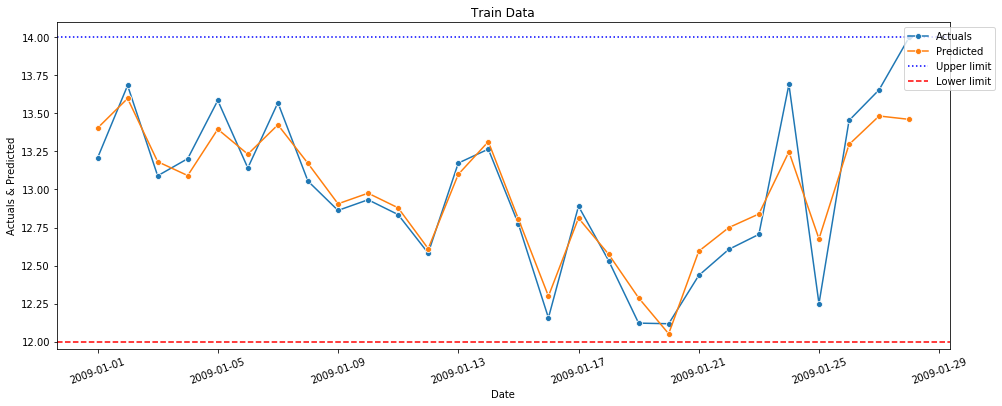

(36, 3)


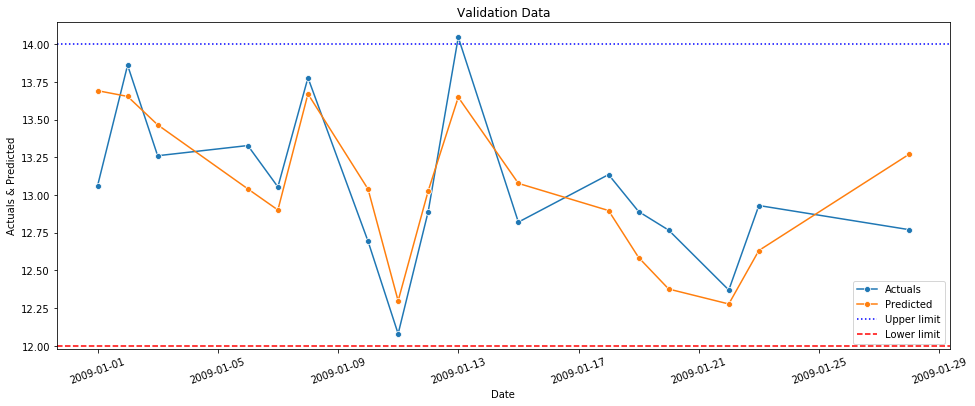

In [94]:
m.series_plot(train_prediction_res, predcition_result, 14, 12)

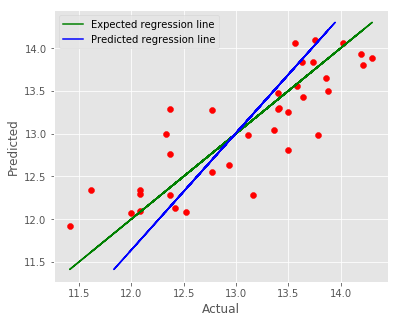

In [74]:
#Plotting the actual vs fitted
m.plot(predcition_result)

In [67]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
0,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
0,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
0,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
0,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
0,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
0,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
0,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
0,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
0,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964


In [68]:
#Getting the results
result = m.model_result_df.reset_index()
result.drop(['index'], inplace = True, axis = 1)
result

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
1,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
2,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
3,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
4,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
5,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
6,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
7,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
8,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
9,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964


### Randomized  Search

In [69]:
####INitialising the parameters to be passed as dictionary

importance_type = ['split', 'gain']
max_bin  = [100, 200, 250, 300, 500]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.01, stop = 0.3, num = 10)]

# Maximum number of levels in tree
max_depth = [-1, 3, 5, 7, 10, 12, 15, 17, 20]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(10, 60, num = 15)]

# Method of selecting samples for training each tree
min_split_gain  = [0, 1,2,3]
eval_metric = ["RMSE", "MAE"]
tree_learner = ['voting','serial']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_split_gain ': min_split_gain ,
              'tree_learner': tree_learner,
              'max_bin': max_bin}

#pprint(random_grid)

In [70]:
#Assigning the estimator
estimator1 = lgb.LGBMRegressor(silent = False)

#Calling function for randomized search
obj2 = m.randomized_search(estimator1, random_grid, 150, 2)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.1s finished


[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 12
[LightGBM] [Info] Start training from score 12.979085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [71]:
obj2.best_params_

{'tree_learner': 'voting',
 'num_leaves': 31,
 'n_estimators': 100,
 'min_split_gain ': 3,
 'max_depth': 17,
 'max_bin': 100,
 'learning_rate': 0.042222222222222223,
 'importance_type': 'gain'}

In [72]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor()

#Fiiting the model using the best params from randomized search
obj = m.fit_model(lgbm_base, obj2.best_params_)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB Model Random search')
eval_res

[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,LGB Model Random search,0.142351,0.377295,0.291462,6.566637,0.786853,0.148358,0.385173,0.312282,6.309531,0.751509


In [73]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
0,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
0,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
0,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
0,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
0,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
0,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
0,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
0,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
0,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964


### Grid Search 

In [74]:
# Initialising the parameters to be passed as dictionary
importance_type = ['gain']
max_bin  = [200]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.03, stop = 0.05, num = 4)]

# Maximum number of levels in tree
max_depth = [14, 16, 17, 19]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(40, 60, num = 4)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
              'max_bin': max_bin}

pprint(random_grid)

{'importance_type': ['gain'],
 'learning_rate': [0.03, 0.03666666666666667, 0.043333333333333335, 0.05],
 'max_bin': [200],
 'max_depth': [14, 16, 17, 19],
 'n_estimators': [50, 162, 275, 387, 500],
 'num_leaves': [40, 46, 53, 60]}


In [75]:
#Assigning the estimator
estimator1 = lgb.LGBMRegressor()

#Calling the grid search function
obj3 = m.grid_search(estimator1, random_grid, 2)

Fitting 2 folds for each of 320 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    7.3s finished


In [76]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor(tree_learner = 'voting',min_split_gain = 2)

#Fiiting the model
obj = m.fit_model(lgbm_base, obj3.best_params_)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB_GridSearch')
eval_res

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,LGB_GridSearch,0.264645,0.514436,0.414005,6.042186,0.603738,0.172313,0.415106,0.328932,5.874293,0.711386


In [77]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
0,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
0,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
0,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
0,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
0,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
0,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
0,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
0,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
0,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964


In [78]:
#Getting the results
result = m.model_result_df.reset_index()
result.drop(['index'], inplace = True, axis = 1)
result

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Linear Model,0.291172,0.539604,0.428738,3.319420,0.564018,0.185716,0.430948,0.367549,2.842298,0.688936
1,Robust Model,0.589666,0.767897,0.559824,4.379633,0.117072,0.377318,0.614262,0.487228,3.757371,0.368015
2,Lasso Model,0.320344,0.565990,0.450818,6.278504,0.520337,0.199258,0.446383,0.388771,6.377037,0.666255
3,Ridge Model,0.291178,0.539610,0.428798,3.319727,0.564008,0.185053,0.430178,0.366857,2.836903,0.690046
4,ElasticNet Model,0.338748,0.582021,0.455655,6.174974,0.492781,0.212974,0.461491,0.398866,6.324855,0.643281
5,PLS Model,0.318976,0.564780,0.440364,3.409629,0.522386,0.179917,0.424166,0.346037,2.675279,0.698650
6,LARS Model,0.564708,0.751470,0.625855,5.371750,0.154444,0.469069,0.684886,0.596978,5.343750,0.214337
7,XGBoost Model,0.000824,0.028702,0.020318,7.218027,0.998766,0.220101,0.469149,0.385013,6.380411,0.631344
8,Random Forest Model,0.245782,0.495764,0.395253,6.299327,0.631982,0.170198,0.412551,0.328286,6.098387,0.714928
9,Decision Tree Model,0.295315,0.543429,0.438578,6.441104,0.557815,0.318838,0.564658,0.448582,6.261892,0.465964
